In [35]:
import pylab as pl
import scipy as sp
import numpy as np
from scipy.linalg import eig
from scipy.io import loadmat
import pdb

In [36]:
def load_data(fname):
    # load the data
    data = loadmat(fname)
    X,Y = data['X'],data['Y']
    # collapse the time-electrode dimensions
    X = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    # transform the labels to (-1,1)
    Y = np.sign((Y[0,:]>0) -.5)
    return X,Y

In [37]:
X,Y = load_data('bcidata.mat')
print(X.shape)
print(Y.shape)


(310, 5322)
(5322,)


In [38]:
def train_ncc(X,Y):
    '''
    Train a nearest centroid classifier
    '''
    # return the weight vector, bias term
    target_idx = np.where(Y == 1)[0]
    non_target_idx = np.where(Y == -1)[0]

    mu_target = np.mean(X[:, target_idx], axis=1)
    mu_non_target = np.mean(X[:, non_target_idx], axis=1)

    w = mu_target - mu_non_target
    
    b = -0.5 * (np.dot(w, mu_target) + np.dot(w, mu_non_target))
    return w,b  

In [39]:
def train_lda(X,Y):
    '''
    Train a linear discriminant analysis classifier
    '''
    # return the weight vector, bias term
    target_idx = np.where(Y == 1)[0]  
    non_target_idx = np.where(Y == -1)[0]
    
    mu_target = np.mean(X[:, target_idx], axis=1, keepdims=True)
    mu_non_target = np.mean(X[:, non_target_idx], axis=1, keepdims=True)

    SB = (mu_target - mu_non_target) @ (mu_target - mu_non_target).T

    SW = np.zeros((X.shape[0], X.shape[0]))
    for i in target_idx:
        SW += np.outer(X[:, i] - mu_target[:, 0], X[:, i] - mu_target[:, 0])
    for j in non_target_idx:
        SW += np.outer(X[:, j] - mu_non_target[:, 0], X[:, j] - mu_non_target[:, 0])

    regularization_term = 0.01 * np.eye(SW.shape[0])
    SW += regularization_term

    eigvals, eigvecs = eig(SB, SW)
    w = eigvecs[:, np.argmax(eigvals.real)].real
    b = 0.5 * (np.dot(w, mu_target[:, 0]) + np.dot(w, mu_non_target[:, 0]))

    return w, b

In [40]:
def compare_classifiers():
    '''
    compares nearest centroid classifier and linear discriminant analysis
    '''
    fname = 'bcidata.mat'
    X,Y = load_data(fname)

    permidx = np.random.permutation(np.arange(X.shape[-1]))
    trainpercent = 70.
    stopat = int(np.floor(Y.shape[-1]*trainpercent/100.))
    # pdb.set_trace()
    
    X,Y,Xtest,Ytest = X[:,permidx[:stopat]],Y[permidx[:stopat]],X[:,permidx[stopat:]],Y[permidx[stopat:]]

    w_ncc, b_ncc = train_ncc(X, Y)

    w_lda, b_lda = train_lda(X, Y)
    fig = pl.figure(figsize=(12,5))

    ax1 = fig.add_subplot(1,2,1)
    # pl.hold(True)
    ax1.hist(w_ncc.dot(Xtest[:,Ytest<0]))
    ax1.hist(w_ncc.dot(Xtest[:,Ytest>0]))
    ax1.set_xlabel('$w^{T}_{NCC}X$')
    ax1.legend(('non-target','target'))
    ax1.set_title("NCC Acc " + str(np.sum(np.sign(w_ncc.dot(Xtest)-b_ncc)==Ytest)*100/Xtest.shape[-1]) + "%")
    ax2 = fig.add_subplot(1,2,2)
    ax2.hist(w_lda.dot(Xtest[:,Ytest<0]))
    ax2.hist(w_lda.dot(Xtest[:,Ytest>0]))
    ax2.set_xlabel('$w^{T}_{LDA}X$')
    ax2.legend(('non-target','target'))
    ax2.set_title("LDA Acc " + str(np.sum(np.sign(w_lda.dot(Xtest)-b_lda)==Ytest)*100/Xtest.shape[-1]) + "%")
    pl.savefig('ncc-lda-comparison.pdf')


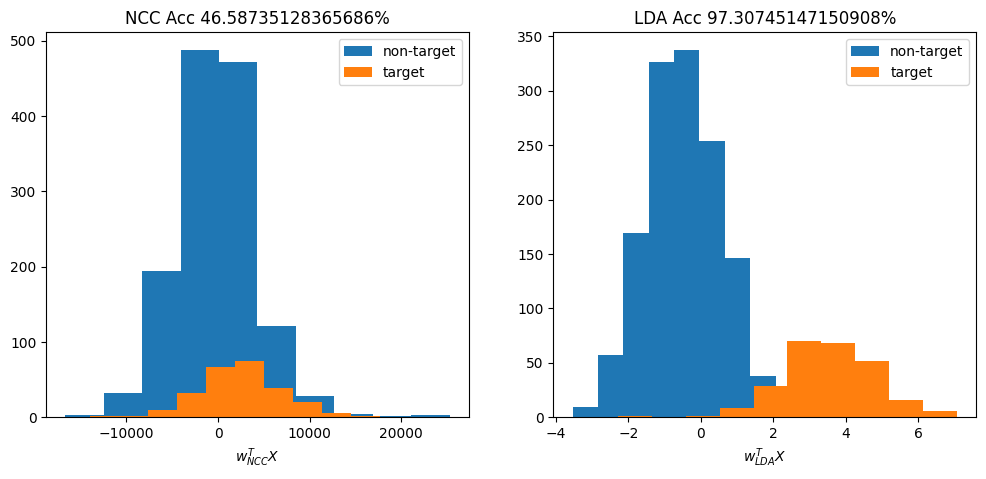

In [41]:
compare_classifiers()

In [42]:
def crossvalidate(X, Y, f=10, trainfunction=train_lda):
    ''' 
    Test generalization performance of a linear classifier
    Input:  X   data (dims-by-samples)
            Y   labels (1-by-samples) assuming labels are {1, -1}
            f   number of cross-validation folds
            trainfunction  trains linear classifier
    '''
    num_samples = X.shape[1]
    fold_size = num_samples // f
    indices = np.random.permutation(num_samples)  # Shuffle indices
    
    acc_train = np.zeros(f)
    acc_test = np.zeros(f)
    
    for ifold in range(f):
        test_indices = indices[ifold * fold_size: (ifold + 1) * fold_size]
        train_indices = np.setdiff1d(indices, test_indices)
        
        X_train, Y_train = X[:, train_indices], Y[train_indices]
        X_test, Y_test = X[:, test_indices], Y[test_indices]
        
        w, b = trainfunction(X_train, Y_train)
        
        predictions_train = np.sign(np.dot(w.T, X_train) + b)
        predictions_test = np.sign(np.dot(w.T, X_test) + b)
        
        acc_train[ifold] = np.mean(predictions_train == Y_train)
        acc_test[ifold] = np.mean(predictions_test == Y_test)

    return acc_train, acc_test

Accuracy on training data:  [0.27098121 0.73528184 0.2782881  0.72442589 0.27223382 0.26638831
 0.27453027 0.27077244 0.27139875 0.26993737]
Accuracy on test data:  [0.29887218 0.70864662 0.2575188  0.73120301 0.29511278 0.2481203
 0.28947368 0.28383459 0.2575188  0.30075188]


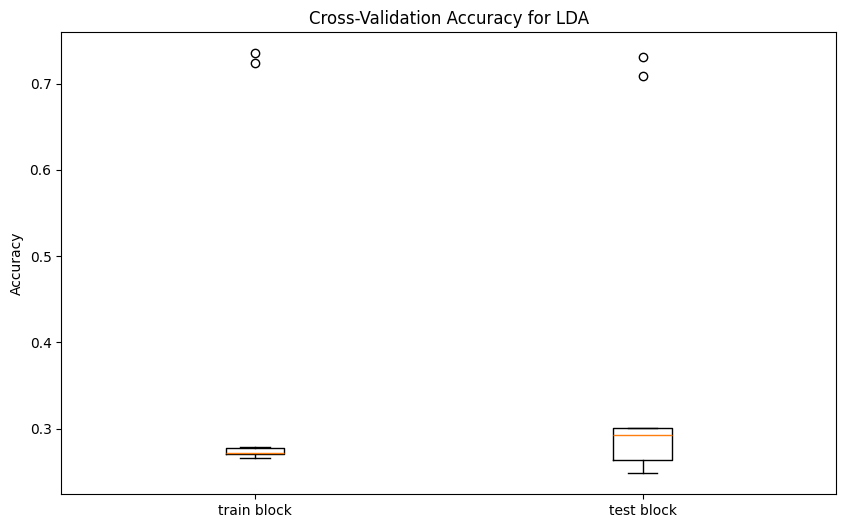

In [43]:
X, Y = load_data('bcidata.mat')
acc_train, acc_test = crossvalidate(X, Y, f=10, trainfunction=train_lda)
print('Accuracy on training data: ', acc_train)
print('Accuracy on test data: ', acc_test)

# Plotting the results
fig = pl.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.boxplot([acc_train, acc_test], labels=['train block', 'test block'])
ax.set_title('Cross-Validation Accuracy for LDA')
ax.set_ylabel('Accuracy')
pl.savefig('cross_validation_accuracy.png')
pl.show()